# Satellite Intelligence for Catastrophic Natural Disaster Recovery: Assessing Damage and First Responder Priorities through Geospatial Imagery

## Jeremiah Fa'atiliga, Ravita Kartawinata, Sowmiya Kanmani Maruthavanan

# Importing Libraries

In [1]:
import os
import json
import pandas as pd
import numpy as np
import cv2
import boto3
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io
from shapely import wkt
from shapely.geometry import mapping

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings("ignore")


The xBD dataset provides annotated high-resolution satellite imagery for assessing building damage, consisting of JSON files and image files. This project focuses on analyzing pre- and post-disaster imagery related to hurricanes.

## Data Loading

In [2]:
# Function to read JSON files
def load_JSON_data(directory):
    pre_data = []
    post_data = []

    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        with open(file_path, 'r') as file:
            content = json.load(file)

        # Filter by hurricane natural disaster only
        disaster = content['metadata'].get('disaster')
        if disaster and "hurricane" in disaster.lower():
            img_name = content['metadata'].get('img_name', "")
            data = {
                'img_name': img_name,
                'xy': content['features'].get('xy'),
                'sensor': content['metadata'].get('sensor'),
                'provider_asset_type': content['metadata'].get('provider_asset_type'),
                'gsd': content['metadata'].get('gsd'),
                'capture_date': content['metadata'].get('capture_date'),
                'off_nadir_angle': content['metadata'].get('off_nadir_angle'),
                'pan_resolution': content['metadata'].get('pan_resolution'),
                'sun_azimuth': content['metadata'].get('sun_azimuth'),
                'sun_elevation': content['metadata'].get('sun_elevation'),
                'target_azimuth': content['metadata'].get('target_azimuth'),
                'disaster': disaster,
                'disaster_type': content['metadata'].get('disaster_type'),
                'catalog_id': content['metadata'].get('catalog_id'),
                'original_width': content['metadata'].get('original_width'),
                'original_height': content['metadata'].get('original_height'),
                'width': content['metadata'].get('width'),
                'height': content['metadata'].get('height'),
                'id': content['metadata'].get('id')
            }
            
            # Separate pre and post DataFrame
            if "pre" in img_name.lower():
                pre_data.append(data)
            elif "post" in img_name.lower():
                post_data.append(data)
    
    hurricane_pre_df = pd.DataFrame(pre_data)
    hurricane_post_df = pd.DataFrame(post_data)
    
    return hurricane_pre_df, hurricane_post_df

In [3]:
# Setup
directory_path = "../Data"
#directory_path = "C:/Users/sowmi/gitworkspace/hurricane/train/labels"

# Loading JSON data into dataframe
hurricane_pre_df, hurricane_post_df = load_JSON_data(directory_path)

## Exploration Data Analysis

In [4]:
# Combine pre and post dataframe
hurricane_pre_df['status'] = 'Pre'
hurricane_post_df['status'] = 'Post'
hurricane_df =  pd.concat([hurricane_pre_df, hurricane_post_df])

In [5]:
hurricane_df.describe()

,gsd,off_nadir_angle,pan_resolution,sun_azimuth,sun_elevation,target_azimuth,original_width,original_height,width,height
count,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.000000,2338.0,2338.0
mean,2.195828,27.078261,0.548674,148.770032,53.948769,204.459031,1024.011976,1024.011976,1024.0,1024.0
std,0.376744,8.279715,0.093463,22.491459,10.479941,99.285437,0.108801,0.108801,0.0,0.0
min,1.503376,9.628279,0.375870,69.757317,35.949000,54.715256,1024.000000,1024.000000,1024.0,1024.0
25%,1.958603,24.512466,0.489478,150.963420,46.697117,112.555626,1024.000000,1024.000000,1024.0,1024.0
50%,2.071191,27.207548,0.517116,153.945430,53.722378,190.823090,1024.000000,1024.000000,1024.0,1024.0
75%,2.201535,28.866730,0.552110,162.031000,63.009785,285.766270,1024.000000,1024.000000,1024.0,1024.0
max,3.146662,44.191100,0.784305,163.926380,74.701843,357.342350,1025.000000,1025.000000,1024.0,1024.0


### Damage Classification by Disaster Type 

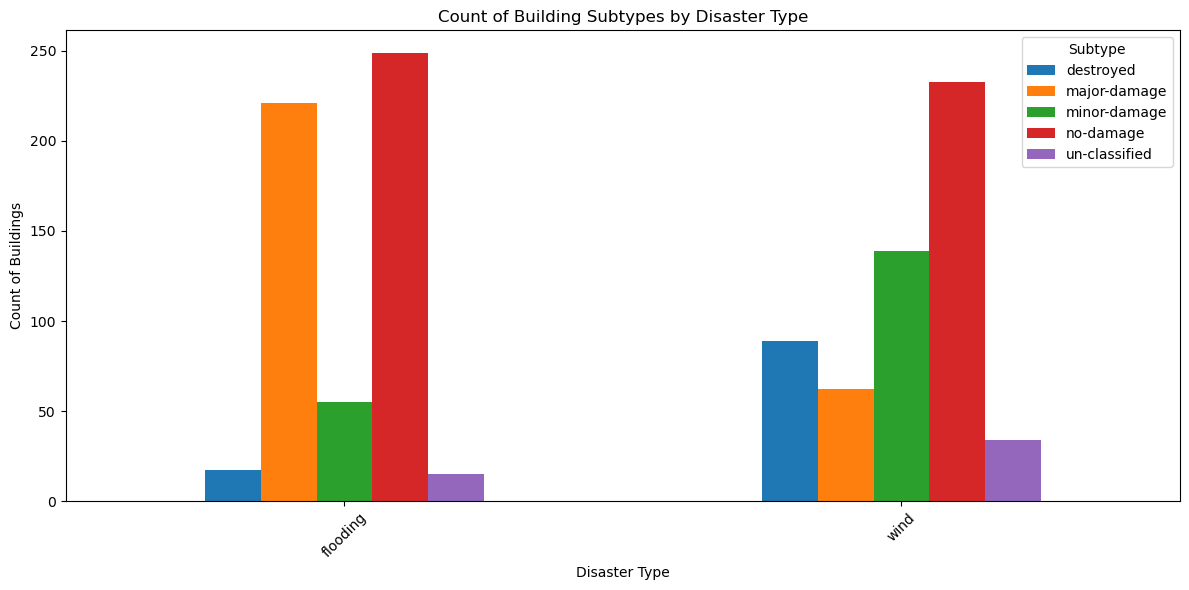

In [6]:
# Extract subtype from xy
hurricane_df['subtype'] = hurricane_df['xy'].apply(
    lambda x: x[0]['properties'].get('subtype') if isinstance(x, list) and len(x) > 0 and 'properties' in x[0] else None
)
counts = hurricane_df.groupby(['disaster_type', 'subtype']).size().unstack(fill_value=0)

# Plotting bar chart for each disaster type
counts.plot(kind='bar', figsize=(12, 6))
plt.title("Count of Building Subtypes by Disaster Type")
plt.xlabel("Disaster Type")
plt.ylabel("Count of Buildings")
plt.xticks(rotation=45)
plt.legend(title="Subtype")
plt.tight_layout()
plt.show()

### 

The barplot shows the count of buildings impacted by two types of disasters: flooding and wind. It's categorized by damage severity. Each disaster type on the x-axis is broken down into five subtypes of building damage: destroyed, major-damage, minor-damage, no-damage, and unclassified. The tall red bars indicate a high count of buildings that sustained no damage in both flooding and wind events. Major-damage (orange) is also prominent in flooding, while minor-damage (green) is more frequent in wind-related incidents. 
The chart provides insight into how different disaster types impact buildings at varying levels of severity especially the impact of flooding.

### Relationship between Features and Disaster Type/Status 

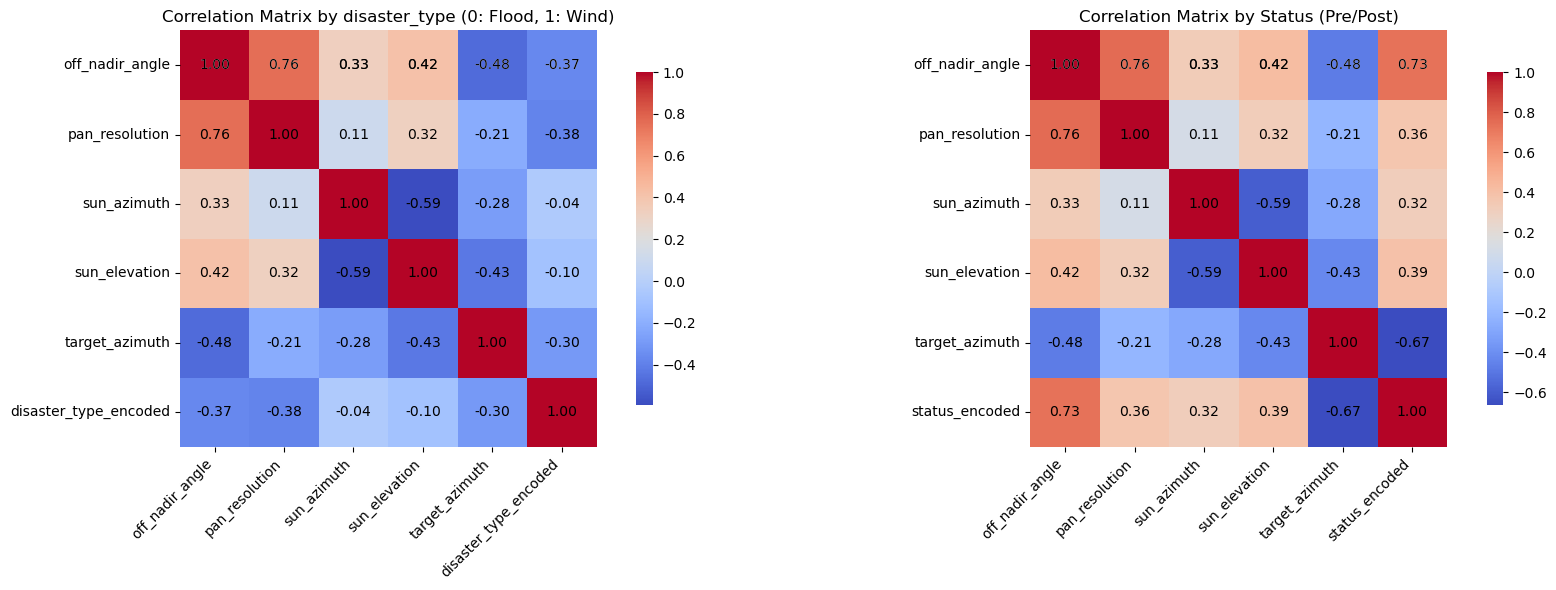

In [7]:
hurricane_df['disaster_type_encoded'] = hurricane_df['disaster_type'].map({'flooding': 0, 'wind': 1})
hurricane_df['status_encoded'] = hurricane_df['status'].map({'Pre': 0, 'Post': 1})

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# First plot: Correlation matrix by disaster_type (0: Flood, 1: Wind)
features_disaster = [
    'off_nadir_angle',
    'pan_resolution',
    'sun_azimuth',
    'sun_elevation',
    'target_azimuth',
    'disaster_type_encoded'
]
correlation_matrix_disaster = hurricane_df[features_disaster].corr()

sns.heatmap(
    correlation_matrix_disaster, annot=True, fmt=".2f", cmap='coolwarm', 
    square=True, cbar_kws={"shrink": .8}, ax=axes[0]
)
axes[0].set_title('Correlation Matrix by disaster_type (0: Flood, 1: Wind)')
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha='right')
axes[0].set_yticklabels(axes[0].get_yticklabels(), rotation=0)

# Add correlation values as text in each cell for disaster_type plot
for i in range(len(correlation_matrix_disaster.columns)):
    for j in range(len(correlation_matrix_disaster.index)):
        axes[0].text(j + 0.5, i + 0.5, f'{correlation_matrix_disaster.iloc[i, j]:.2f}',
                     ha='center', va='center', color='black', fontsize=10)

# Second plot: Correlation matrix by Status (Pre/Post)
features_status = [
    'off_nadir_angle',
    'pan_resolution',
    'sun_azimuth',
    'sun_elevation',
    'target_azimuth',
    'status_encoded'
]
correlation_matrix_status = hurricane_df[features_status].corr()

sns.heatmap(
    correlation_matrix_status, annot=True, fmt=".2f", cmap='coolwarm', 
    square=True, cbar_kws={"shrink": .8}, ax=axes[1]
)
axes[1].set_title('Correlation Matrix by Status (Pre/Post)')
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha='right')
axes[1].set_yticklabels(axes[1].get_yticklabels(), rotation=0)

# Add correlation values as text in each cell for status plot
for i in range(len(correlation_matrix_status.columns)):
    for j in range(len(correlation_matrix_status.index)):
        axes[1].text(j + 0.5, i + 0.5, f'{correlation_matrix_status.iloc[i, j]:.2f}',
                     ha='center', va='center', color='black', fontsize=10)

plt.tight_layout()
plt.show()


The two correlation matrices provide valuable information about various satellite observation related to disaster types and statuses natural disasters. The color and values show correlations between each features. Red represents positive correlations, while blue represents negative correlations.

In general, the correlation between numerical features (off_nadir_angle, pan_resolution) is consistent between these two plots:
- Off_nadir_angle and pan_resolution are highly correlated, suggesting that as the angle of the satellite increases from nadir (directly overhead), the spatial resolution of the image may change.
- The angle of the satellite from directly overhead (off_nadir_angle) and the sun’s position above the horizon (sun_elevation) are moderately linked, meaning these factors tend to increase together but not as strongly as above.
 
The first plot on the left examines the correlation between features such as off_nadir_angle, pan_resolution, and disaster_type_encoded, which categorizes observations as either flooding (0) or wind (1). .
- Disaster type (disaster_type_encoded) has a weak negative correlation with most factors, like the sun’s angle and the satellite’s angle. This suggests a slight tendency for certain angles and sun positions to differ between wind and flood imagery.
- Disaster type shows a moderate negative correlation with the satellite angle and image resolution, meaning that wind-related images tend to have lower satellite angles and better resolution than flood images.

The second plot on the right focuses on the correlation with status_encoded, indicating observations taken before (0) and after (1) a disaster, allowing for the assessment of changes in features due to the disaster's impact. 
- "off_nadir_angle" has a strong positive correlation with "status_encoded." This suggests that the "off_nadir_angle" tends to increase when the status changes from "Pre" to "Post."
- "pan_resolution" shows a moderate positive correlation with "status_encoded," indicating a slight increase in "pan_resolution" with the status change.
- "sun_azimuth" and "sun_elevation" exhibit weak negative correlations with "status_encoded," suggesting a slight decrease in these variables with the status change.
- "target_azimuth" has a strong negative correlation with "status_encoded," indicating a significant decrease in "target_azimuth" when the status changes from "Pre" to "Post."

The numerical features do not have a strong correlation with disaster_type_encoded, and in fact, exhibit a negative correlation. Conversely, off_nadir_angle shows a strong correlation with status_encoded (Pre/Post), but displays a negative correlation with the target_azimuth feature.
In addition, when there's high correlation between features in features_status, it might be worth considering feature selection or dimensionality reduction techniques to avoid issues like multicollinearity in modeling.

In [8]:
### Polygon Shape plot sampling before and after disaster

In [9]:
# Sampling hurricane michael pre-post
filtered_df = hurricane_df[hurricane_df['img_name'].str.contains('hurricane-michael')]
filtered_df['wkt'] = filtered_df['xy'].apply(
    lambda x: x[0].get('wkt') if isinstance(x, list) and len(x) > 0 else None
)
# Use .loc to assign 'polygon_shape' 
filtered_df.loc[:, 'polygon_shape'] = filtered_df['wkt'].apply(wkt.loads)


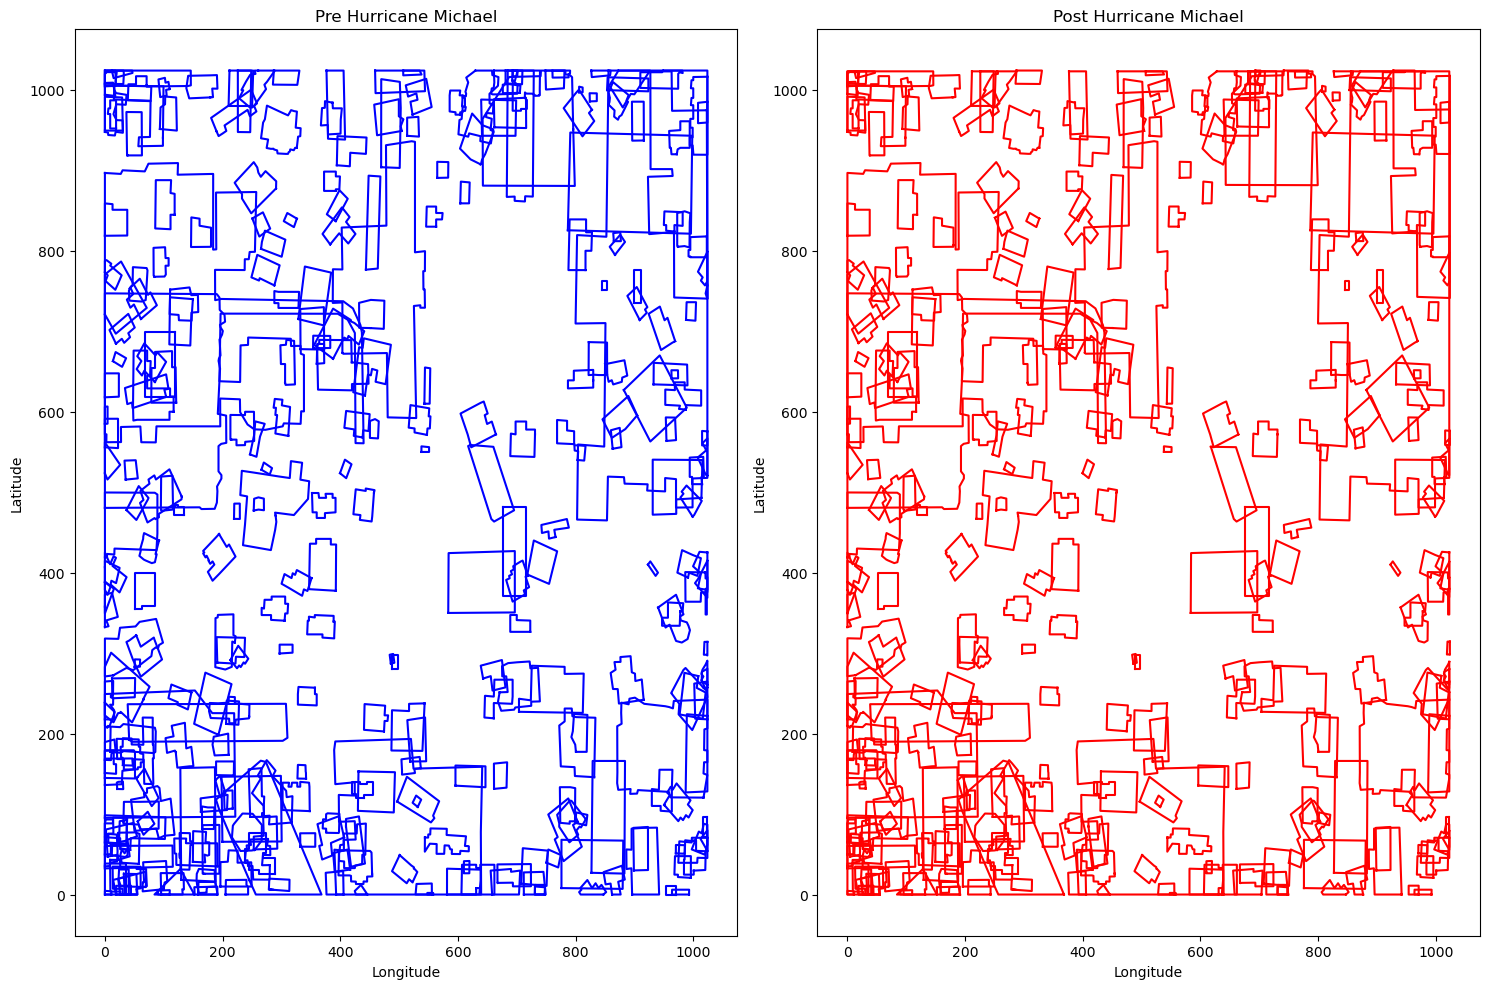

In [10]:
fig, (ax_pre, ax_post) = plt.subplots(1, 2, figsize=(15, 10))

# Plotting Pre Hurricane Data
pre_data = filtered_df[filtered_df['status'] == 'Pre']
for idx, row in pre_data.iterrows():
    if row['polygon_shape'] is not None:
        ax_pre.plot(*row['polygon_shape'].exterior.xy, color='blue', label='Pre' if idx == pre_data.index[0] else "")

ax_pre.set_title('Pre Hurricane Michael')
ax_pre.set_xlabel('Longitude')
ax_pre.set_ylabel('Latitude')

# Plotting Post Hurricane Data
post_data = filtered_df[filtered_df['status'] == 'Post']
for idx, row in post_data.iterrows():
    if row['polygon_shape'] is not None:
        ax_post.plot(*row['polygon_shape'].exterior.xy, color='red', label='Post' if idx == post_data.index[0] else "")
        
ax_post.set_title('Post Hurricane Michael')
ax_post.set_xlabel('Longitude')
ax_post.set_ylabel('Latitude')

# Adjust layout
plt.tight_layout()
plt.show()

the polygon points for post-disaster cannot be used for training the model as they are the same for pre- and post-disaster. polygon the pre and the post to show that there is no impact on the structure on the property ........ to be continued


## Loading the images

In [13]:
# Function to load pre- and post- disaster images
def load_images(filename) :
    
    image_path = os.path.join(image_folder, filename)
    
    # Reading the image
    image = cv2.imread(image_path)
    
    # Convert image from BGR to RGB format
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    return rgb_image

In [14]:
# S3 Bucket Name & Image Directory Location
S3_Bucket_Name = 'hurricaneimagebucket'  
Image_Directory = '../Images'

# boto3 to initialize S3 client
s3_client = boto3.client('s3')

# S3 Bucket Download Images Function
def S3_Download(S3_Bucket_Name, Image_Directory):
    # Objects list within S3 Bucket
    S3_Response = s3_client.list_objects_v2(Bucket = S3_Bucket_Name)

    # Check if the bucket contains any objects
    if 'Contents' in S3_Response:
        for S3_Object in S3_Response['Contents']:
            file_name = S3_Object['Key']

            # Check if file is .png if want to add other formats i.e. file_name.endswith(('.png','.jpeg'))
            if file_name.endswith('.png'):  # Image format
                # Uncomment line below if you are requiring to see the downloads
                # print(f'Downloading {file_name}...')

                # Join Path
                Image_path = os.path.join(Image_Directory, file_name)

                # Create any necessary directories
                os.makedirs(os.path.dirname(Image_path), exist_ok = True)

                # Download the image
                s3_client.download_file(S3_Bucket_Name, file_name, Image_path)
                # Uncomment line below if you are requiring to see the downloads
                # print(f'Image downloaded {file_name}')
    else:
        print('No images found in the bucket')

# Call the function
S3_Download(S3_Bucket_Name, Image_Directory)


KeyboardInterrupt



In [ ]:
image_folder = "C:/Users/sowmi/Python scripts/hurricane/images"

pre_hurricane_images = []
pre_image_size = []

post_hurricance_images = []
post_image_size = []

for index, row in hurricane_pre_df.iterrows() :
    img_filename = row['img_name']
    img = load_images(img_filename)
    size = img.shape
    pre_hurricane_images.append(img)
    pre_image_size.append(size)

for index, row in hurricane_post_df.iterrows() :
    img_filename = row['img_name']
    img = load_images(img_filename)
    size = img.shape
    post_hurricance_images.append(img)
    post_image_size.append(size)

In [ ]:
# Assigning image size to a new column
hurricane_pre_df['image_size'] = pre_image_size
hurricane_post_df['image_size'] = post_image_size

In [ ]:
# Displaying the images
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display pre-disaster images 
for i in range(3) :
    axes[0, i].imshow(pre_hurricane_images[i])
    axes[0, i].axis('off')

# Display post-disaster images 
for i in range(3) :
    axes[1, i].imshow(post_hurricance_images[i])
    axes[1, i].axis('off')

axes[0,0].set_title("Pre-disaster images")
axes[1,0].set_title("Post-disaster images")
plt.show()

## Exploratory Data Analysis

## Data Preprocessing

### Mask polygons and locate buildings

In [ ]:
# Function to get polygon annotations for each building
def get_polygon_annotations(feature) :
    poly_annotations = {}
    
    for feat in feature :
        # Convert string format to polygon object
        feat_shape = wkt.loads(feat['wkt'])
        
        # Extract coordinates of the polygon in a tuple
        coords = list(mapping(feat_shape)['coordinates'][0])
        
        # Store unique id and coordinates for each building as a Numpy array
        poly_annotations[feat['properties']['uid']] = (np.array(coords, np.int32))
        
    return poly_annotations

In [ ]:
# Function to locate buildings using polygon annotations
def mask_polygons(size, poly_annotations) :

    # Creating black empty mask image 
    mask_img = np.zeros(size, dtype=np.uint8)
    
    for points in poly_annotations :
        
        # Creating empty mask image to hold one polygon 
        blank_img = np.zeros(size, dtype=np.uint8)
        
        # Extract list of points to locate the building
        poly = poly_annotations[points]
        
        # Fill the blank image with polygon points 
        cv2.fillPoly(blank_img, [poly], (1, 1, 1))
        
        # Draw the border around the polygon
        cv2.polylines(blank_img, [poly], isClosed=True, color=(2, 2, 2), thickness=2)
        
        # Adding the filled image to the main mask image
        mask_img += blank_img
    
    # Set pixel values greater than 2 to 0 to retain non-overlapping areas
    mask_img[mask_img > 2] = 0
    
    # Convert non-overlapping areas to white to locate buildings
    mask_img[mask_img == 1] = 255
    mask_img[mask_img == 2] = 127
    
    return mask_img

In [ ]:
pre_hurricane_mask_images = []

for index, row in hurricane_pre_df.iterrows() :
    feature = row['xy']
    poly_annotations = get_polygon_annotations(feature)
    size = row['image_size']
    mask_image = mask_polygons(size, poly_annotations)
    pre_hurricane_mask_images.append(mask_image)

### Displaying original and masked images

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Display original images 
for i in range(3) :
    axes[0, i].imshow(pre_hurricane_images[i])
    axes[0, i].axis('off')

# Display masked images 
for i in range(3) :
    axes[1, i].imshow(pre_hurricane_mask_images[i])
    axes[1, i].axis('off')

axes[0,0].set_title("Original pre-disaster images")
axes[1,0].set_title("Masked pre-disaster images")
plt.show()

## Modeling for building localization